In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm


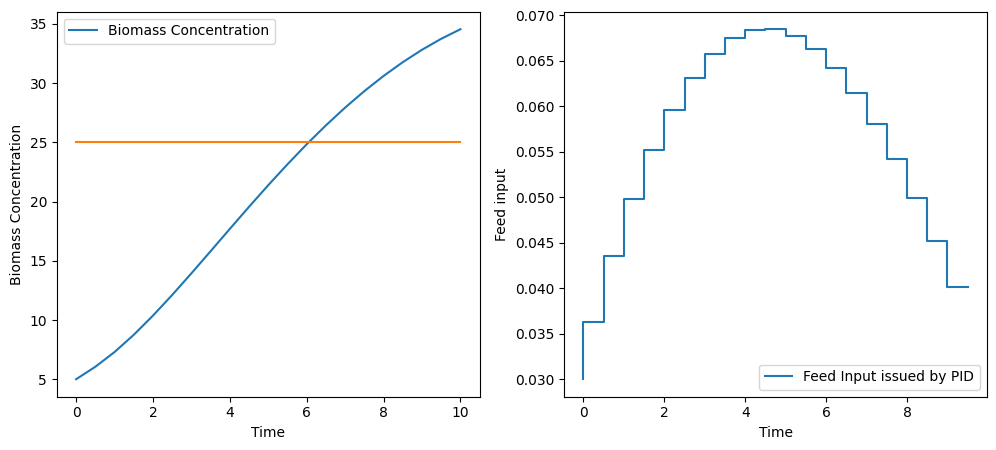

In [15]:
# Kinetic parameters

mu_max = 0.86980  # 1/h
Ks = 0.000123762  # g/l
Yxs= 0.435749     # g/g
Sin= 286          # g/l

# Initial conditions
X0 = 5
S0 = 0.013
V0 = 1.7
F0 = 0.01 #L/h

# PID Step
dt = 0.5

# Absolute time
At=10
#Simulation Steps
SS=int(At/dt)

F_min=0
F_max=0.1

# Υπολογισμός των PID παραμέτρων βάσει IMC
Kp =  0.001
Ki =  0.001
Kd =  0.001


integral_error = 0
prev_error = 0
method="PID"


# Ορισμός των διαφορικών εξισώσεων που περιγράφουν το μοντέλο
def plant_model(t, y, F):
    X, S, V = y
    S=max(S,0)
    dX_dt = (mu_max * S / (Ks + S)) * X - (F / V) * X
    dS_dt = -(1 / Yxs) * (mu_max * S / (Ks + S)) * X + (F / V) * (Sin - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

# Ορισμός του setpoint ως συνάρτηση του χρόνου
def Cb_set(t):
    return 25

# PID CONTROLLER
def PID(t, X,method):
    global integral_error, prev_error
    err = Cb_set(t) - X
    integral_error += err * dt  # Ολοκλήρωμα
    derivative_error = (err - prev_error) / dt if t > 0 else 0  # Παράγωγος
    prev_error = err

    if method=="PID":
        # Υπολογισμός PID εξόδου
        F_out = Kp * err + Ki * integral_error + Kd * derivative_error
    elif method=="PI":
        F_out=Kp * err + Ki * integral_error
    else:
        F_out=Kp * err

    # Περιορισμός της παροχής μεταξύ 0 και 0.1 L/h
    return np.clip(F_out, F_min, F_max)


# Αρχικοποίηση συστήματος
X = np.zeros(SS+1)
S = np.zeros(SS+1)
V = np.zeros(SS+1)
F_PID = np.zeros(SS)

X[0], S[0], V[0] = X0, S0, V0

# PID FEEDBACK LOOP
for step in range(SS):
    t = step * dt
    F_PID[step] = PID(t, X[step],method)  # Το F πρέπει να είναι μη αρνητικό
    solution = solve_ivp(
        plant_model, t_span=(t, t+dt), y0=[X[step], S[step], V[step]], args=(F_PID[step],)
    )
    X[step+1], S[step+1], V[step+1] = solution.y[:, -1]

# Γράφημα αποτελεσμάτων
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


ax = axs[0]
ax.plot(np.arange(0, At+dt, dt), X, label="Biomass Concentration")
ax.plot(np.arange(0,At+dt,dt),[Cb_set(t) for t in np.arange(0,At+dt,dt)])
ax.set_xlabel('Time')
ax.set_ylabel('Biomass Concentration')
ax.legend()

ax = axs[1]
ax.step(np.arange(0, At, dt), F_PID, label="Feed Input issued by PID")
ax.set_xlabel('Time')
ax.set_ylabel('Feed input')
ax.legend()

plt.show()
